In [1]:
from langchain_openai import ChatOpenAI
import os

In [2]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="dotenv.txt");

In [3]:
MODEL_NAME = os.getenv('LLAMA4_SCOUT_17B_QUANT_MODEL_NAME')
MODEL_API_KEY = os.getenv('LLAMA4_SCOUT_17B_QUANT_API_KEY')
MODEL_BASE_URL = os.getenv('LLAMA4_SCOUT_17B_QUANT_BASE_URL')

In [4]:
llm = ChatOpenAI(model=MODEL_NAME,
                 openai_api_key = MODEL_API_KEY,
                 openai_api_base = f"{MODEL_BASE_URL}/v1")

In [5]:
%run tool_list_operators-v2.ipynb

Loaded in-cluster configuration


In [6]:
%run tool_summarize_states-v2.ipynb

In [7]:
%run tool_prometheus-v2.ipynb

In [8]:
%run tool_mlasp-v2.ipynb

/opt/app-root/lib64/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
%run tool_rag-v2.ipynb

In [10]:
tools = [tool_list_openshift_operators, tool_query_prometheus_metrics, tool_get_prometheus_metric_data_range, 
         tool_plot_prometheus_metric_data_range_as_file, tool_calculate_time_information,
         tool_summarize_pod_states, tool_summarize_service_states,
         tool_wiremock_configuration_predictor, tool_retriever
        ]

In [11]:
type(tools)

list

In [12]:
type(tool_list_openshift_operators)

function

In [13]:
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [14]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using tools to retrieve information to answer questions about OpenShift, the services and applications running inside it.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

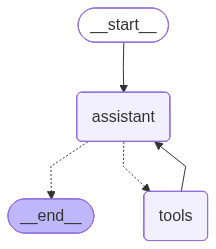

In [15]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [16]:
messages = [HumanMessage(content="hi, who are you?")]
messages = react_graph.invoke({"messages": messages})

In [17]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

hi, who are you?
================================== Ai Message ==================================

I'm an AI assistant designed to help users with information and tasks related to OpenShift, a Kubernetes distribution for the enterprise. I can provide information on OpenShift operators, services, applications, and more. I can also perform tasks such as listing OpenShift operators, summarizing pod and service states, and querying Prometheus metrics.

I'm here to help answer your questions and provide assistance with OpenShift-related topics. What can I help you with today?


In [18]:
messages=[HumanMessage(content="What operators are in namespace demo?")]

In [19]:
messages = react_graph.invoke({"messages": messages})

In [20]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What operators are in namespace demo?
================================== Ai Message ==================================
Tool Calls:
  tool_list_openshift_operators (chatcmpl-tool-6113598d3b2548ebb6f90eb13de6cef8)
 Call ID: chatcmpl-tool-6113598d3b2548ebb6f90eb13de6cef8
  Args:
    namespace: demo
================================= Tool Message =================================
Name: tool_list_openshift_operators

[{"name": "authorino-operator", "namespace": "demo", "version": "1.2.2", "status": "Succeeded"}, {"name": "kiali-operator", "namespace": "demo", "version": "2.11.3", "status": "Succeeded"}, {"name": "openshift-pipelines-operator-rh", "namespace": "demo", "version": "1.19.3", "status": "Succeeded"}, {"name": "prometheusoperator", "namespace": "demo", "version": "0.56.3", "status": "Succeeded"}, {"name": "rhods-operator", "namespace": "demo", "version": "2.22.1", "status": "Succeeded"}, {"name": "ser

In [21]:
messages["messages"][-1].pretty_print()

================================== Ai Message ==================================

The operators in namespace demo are:

1. authorino-operator (version 1.2.2, status Succeeded)
2. kiali-operator (version 2.11.3, status Succeeded)
3. openshift-pipelines-operator-rh (version 1.19.3, status Succeeded)
4. prometheusoperator (version 0.56.3, status Succeeded)
5. rhods-operator (version 2.22.1, status Succeeded)
6. serverless-operator (version 1.36.0, status Succeeded)
7. servicemeshoperator (version 2.6.10-0, status Succeeded)
8. tempo-operator (version 0.16.0-2, status Succeeded)


In [22]:
messages=[HumanMessage(content="What configuration of WireMock supports a throughput KPI of 307 within a 2.9 percent precision? Search for 100 epochs to find the result.")]

In [23]:
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

/opt/app-root/lib64/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlasp-mlasp-datascience.apps.cluster-nr48j.nr48j.sandbox1693.opentlc.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/opt/app-root/lib64/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlasp-mlasp-datascience.apps.cluster-nr48j.nr48j.sandbox1693.opentlc.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/opt/app-root/lib64/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlasp-mlasp-datascience.apps.cluster-nr48j.nr48j.sandbox1693.opentlc.com'. Adding certificate verificatio

================================ Human Message =================================

What configuration of WireMock supports a throughput KPI of 307 within a 2.9 percent precision? Search for 100 epochs to find the result.
================================== Ai Message ==================================
Tool Calls:
  tool_wiremock_configuration_predictor (chatcmpl-tool-0f5c53c59e41474796c0efacf1ef3473)
 Call ID: chatcmpl-tool-0f5c53c59e41474796c0efacf1ef3473
  Args:
    epochs: 100
    KPI_value: 307
    precision: 2.9
================================= Tool Message =================================
Name: tool_wiremock_configuration_predictor

{"Parameters": {"asyncResp": 1, "asyncRespThreads": 16, "cThreads": 138, "jacptQSize": 1650, "jacptThreads": 227, "ltTargetSize": 9, "numConnections": 32, "timeoutSeconds": 4}, "Deviation": 1.3953469651320352, "Prediction": 311.28371518295535}
================================== Ai Message ==================================

The configuration of WireMo

In [24]:
messages["messages"][-1].pretty_print()

================================== Ai Message ==================================

The configuration of WireMock that supports a throughput KPI of 307 within a 2.9 percent precision is:

{
    "asyncResp": 1,
    "asyncRespThreads": 16,
    "cThreads": 138,
    "jacptQSize": 1650,
    "jacptThreads": 227,
    "ltTargetSize": 9,
    "numConnections": 32,
    "timeoutSeconds": 4
}

This configuration was found after searching for 100 epochs. The predicted throughput KPI value is 311.28, which is within the 2.9 percent precision boundary of the target KPI value of 307.


In [25]:
messages=[HumanMessage(content="Find out the Prometheus service name and port number running in namespace demo. Use it to to plot all the prometheus metric data for the metric load_generator_total_msg starting 48 hours ago until now. You must calculate the two timestamps before retrieving the metrics. Return only the filename provided by the tool and nothing else.")]

In [26]:
messages = react_graph.invoke({"messages": messages})

Exception when plotting metric range data: HTTPConnectionPool(host='prometheus-service.demo.svc.cluster.local', port=9090): Max retries exceeded with url: /api/v1/query?query=load_generator_total_msg%5B2591800s%5D&time=1646315200 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x7f619846ec10>: Failed to resolve 'prometheus-service.demo.svc.cluster.local' ([Errno -2] Name or service not known)"))
Exception when plotting metric range data: HTTPConnectionPool(host='prometheus.demo.svc.cluster.local', port=9090): Max retries exceeded with url: /api/v1/query?query=load_generator_total_msg%5B2591800s%5D&time=1646315200 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x7f61997e09d0>: Failed to resolve 'prometheus.demo.svc.cluster.local' ([Errno -2] Name or service not known)"))


In [27]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Find out the Prometheus service name and port number running in namespace demo. Use it to to plot all the prometheus metric data for the metric load_generator_total_msg starting 48 hours ago until now. You must calculate the two timestamps before retrieving the metrics. Return only the filename provided by the tool and nothing else.
================================== Ai Message ==================================
Tool Calls:
  tool_calculate_time_information (chatcmpl-tool-1358a8cc40b541cdbde12069da493454)
 Call ID: chatcmpl-tool-1358a8cc40b541cdbde12069da493454
  Args:
    time_value: 48
    time_metric: hours
    ago_flag: 1
  tool_calculate_time_information (chatcmpl-tool-dd1e3f1e5cde4fe3ad5cf6c1cefe2444)
 Call ID: chatcmpl-tool-dd1e3f1e5cde4fe3ad5cf6c1cefe2444
  Args:
    time_value: now
    time_metric: 
    ago_flag: 0
  tool_list_openshift_services (chatcmpl-tool-89e86972b903454e8c6c805e00e29e33)
 C

In [28]:
messages["messages"][-1].pretty_print()

================================== Ai Message ==================================

FILE-plot-load_generator_total_msg-1758055847-1758228647.png


In [28]:
messages=[HumanMessage(content="I want a short step by step summary on how to create a Data Science Project in OpenShift AI")]

In [29]:
messages = react_graph.invoke({"messages": messages})

In [30]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

I want a short step by step summary on how to create a Data Science Project in OpenShift AI
================================== Ai Message ==================================
Tool Calls:
  openshift_ai_documentation_search_tool (chatcmpl-tool-aa5b9bb656a04877896841a795f16293)
 Call ID: chatcmpl-tool-aa5b9bb656a04877896841a795f16293
  Args:
    query: Create Data Science Project in OpenShift AI
================================= Tool Message =================================
Name: openshift_ai_documentation_search_tool

CHAPTER 3. WORKING ON DATA SCIENCE PROJECTS
As a data scientist, you can organize your data science work into a single project. A data science project
in OpenShift AI can consist of the following components:
Workbenches
Creating a workbench allows you to add a Jupyter notebook to your project.
Cluster storage
For data science projects that require data to be retained, you can add cluster stora

In [31]:
messages["messages"][-1].pretty_print()

================================== Ai Message ==================================

Here is a short step-by-step summary on how to create a Data Science Project in OpenShift AI:

1. Log in to Red Hat OpenShift AI.
2. Click on "Data Science Projects" from the OpenShift AI dashboard.
3. Click on "Create data science project".
4. Enter a name for your data science project.
5. Optional: Edit the resource name for your data science project.
6. Enter a description for your data science project.
7. Click "Create".

A project details page will open, where you can create workbenches, add cluster storage and data connections, import pipelines, and deploy models.

Note: You need to have the necessary permissions (e.g., part of the user group or admin group) and the project will be displayed on the "Data science projects" page.


In [32]:
messages=[HumanMessage(content="Give me a summary of the running pods in namespace demo. Please include service and route information in the response.")]

In [33]:
messages = react_graph.invoke({"messages": messages})

In [34]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me a summary of the running pods in namespace demo. Please include service and route information in the response.
================================== Ai Message ==================================
Tool Calls:
  tool_summarize_pod_states (chatcmpl-tool-d970b87fbddb43f887fa19a6311516fb)
 Call ID: chatcmpl-tool-d970b87fbddb43f887fa19a6311516fb
  Args:
    namespace: demo
================================= Tool Message =================================
Name: tool_summarize_pod_states

{"namespace": "demo", "pod_states": {"Succeeded": {"count": 242, "running_pods": []}, "Running": {"count": 3, "running_pods": [{"name": "influxdb-8646648598-v24ft", "service": {"name": "influxdb", "ports": [{"port": 8086, "name": "No name", "protocol": "TCP"}], "route": "unavailable"}}, {"name": "prometheus-operator-5c99989bbf-g7kxq", "service": {"name": "unavailable", "ports": [], "route": "unavailable"}}, {"name": "prometheu

In [36]:
messages["messages"][-1].pretty_print()

================================== Ai Message ==================================

The pods in the demo namespace are summarized as follows:

* Succeeded: 242
* Running: 3

The running pods are:
* influxdb-8646648598-v24ft
* prometheus-operator-5c99989bbf-g7kxq
* prometheus-prometheus-demi-0

The services in the demo namespace are summarized as follows:

* influxdb: 
  - port: 8086
  - route: unavailable
* load-generator: 
  - port: 9090
  - port: 9100
  - route: unavailable
* prometheus-operated: 
  - port: 9090
  - port: 10901
  - route: http://route-comparative-ptarmigan-demo.apps.cluster-nr48j.nr48j.sandbox1693.opentlc.com/

The routes in the demo namespace are summarized as follows:

* http://route-comparative-ptarmigan-demo.apps.cluster-nr48j.nr48j.sandbox1693.opentlc.com/


In [ ]:
res = agent_executor_react_chat.invoke({"input": "What operators are in namespace demo?"})

In [ ]:
print(res['output'])

In [ ]:
res = agent_executor_react_chat.invoke({"input": "What configuration of WireMock supports a throughput KPI of 307 within a 2.9 percent precision? Search for 100 epochs to find the result."})

In [ ]:
print(res['output'])

In [ ]:
res = agent_executor_react_chat.invoke({"input": "How can I create a Data Science Project?"})

In [ ]:
print(res['output'])

In [ ]:
res = agent_executor_react_chat.invoke({"input": "What operators are in namespace demo? Please provide only the name and the version for each operator."})
print(res['output'])

In [ ]:
print(agent_executor_react_chat.invoke({"input": "Can you describe Paris in 100 words or less?"})['output'])

In [ ]:
print(agent_executor_react_chat.invoke({"input": "Is there a river?"})['output'])

In [ ]:
res = agent_executor_react_chat.invoke({"input": "Tell me about the pods in namespace demo"})
print(res['output'])

In [ ]:
result = agent_executor_react_chat.invoke({"input": "Give me a summary of the running pods in namespace demo. Please include service and route information in the response."})

In [ ]:
print(result['output'])

In [ ]:
result = agent_executor_react_chat.invoke({"input": "Give the complete summary of the pods in namespace demo."})

In [ ]:
print(result['output'])

In [ ]:
# This call breaks if we don't set handle_parsing_errors=True at the agent creation
print(agent_executor_react_chat.invoke({"input": "What day is today?"})['output'])

In [ ]:
print(agent_executor_react_chat.invoke({"input": "What is the current date time?"})['output'])

In [ ]:
print(agent_executor_react_chat.invoke({"input": "What is the current timestamp?"})['output'])

In [ ]:
print(agent_executor_react_chat.invoke({"input": "What is the timestamp and date time for 3 hours ago?"})['output'])

In [ ]:
print(agent_executor_react_chat.invoke({"input": "What is the timestamp and date time for 3 hours from now?"})['output'])

In [ ]:
result = agent_executor_react_chat.invoke({"input": "Give me a summary of the running pods in namespace demo. Give me only the names and the route if they have one."})

In [ ]:
print(result['output'])

In [ ]:
result = agent_executor_react_chat.invoke(input={"input": "Is there a prometheus service running in namespace demo? If so, give me its name and port values."})

In [ ]:
print(result['output'])

In [ ]:
result = agent_executor_react_chat.invoke(input = {"input": "Find out the service name and port number of the Prometheus service running in namespace demo. Then use that information to retrieve the list of metrics filtered by namespace demo."})

In [ ]:
print(result['output'])

In [ ]:
result = agent_executor_react_chat.invoke(input = {"input": "Use the Prometheus service name and port number running in namespace demo to get all the metrics that have a name that starts with load_generator."})

In [ ]:
print(result['output'])

In [ ]:
result = agent_executor_react_chat.invoke({"input": "Use the Prometheus service name and port number running in namespace demo to get all the prometheus metric data for the metric load_generator_total_msg starting 72 hours ago until now. Print out only the metric values and their associated timestamp as a CSV table."})

In [ ]:
result = agent_executor_react_chat.invoke({"input": "Find out the Prometheus service name and port number running in namespace demo. Use it to to plot all the prometheus metric data for the metric load_generator_total_msg starting 48 hours ago until now. Return only the content string of the tool and nothing else."})

In [ ]:
result

In [ ]:
result['output']

In [ ]:
result = agent_executor_react_chat.invoke({"input": "Find out the Prometheus service name and port number running in namespace demo. Use it to to plot all the prometheus metric data for the metric load_generator_total_msg starting 120 hours ago until now. Return only the content string of the tool and nothing else."})

In [ ]:
from IPython import display

In [ ]:

display.HTML(result['output'])

In [ ]:
len("iVBORw0KGgoAAAANSUhEUgAAA+gAAAJYCAYAAADxHswlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAABAxUlEQVR4nO3deZzVdb348fewzQAjICDDIgLiggiC4YXABTWMjDSy3EOYXNKklMlSUhmXBLMyvKZR7pVeyTVvGsZFaFGKZOm6oSkgZYIsKgoKw8z394c/zm0cQEA45zPwfD4ePB6ez3y/c97n8JmR15wz5xRlWZYFAAAAUFANCj0AAAAAINABAAAgCQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAGAABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECHQAAABIg0AEAACABAh0AAAASINABAAAgAQIdAAAAEiDQAQAAIAECH")

In [ ]:
get_prometheus_metric_data_range('{"prom_service": "prometheus-operated", "prom_namespace": "demo", "prom_port": 9090, "metric_name": "load_generator_total_msg", "metric_range_start": 1720126396.412619, "metric_range_end": 1720135304.917175}')

In [ ]:
#Respond only with the complete, not truncated content of the response object!!!

In [ ]:
img2 = plot_prometheus_metric_data_range('{"prom_service": "prometheus-operated", "prom_namespace": "demo", "prom_port": 9090, "metric_name": "load_generator_total_msg", "metric_range_start": 1720126396.412619, "metric_range_end": 1720295156.060042}')

In [ ]:
len(img2.plot_base64)

In [ ]:
#display.HTML(f'<{img2.plot_base64}>')
display.HTML(f'<img src="data:image/png;base64,{img2.plot_base64}"/>')

In [ ]:
img_tag = plot_prometheus_metric_data_range('{"prom_service": "prometheus-operated", "prom_namespace": "demo", "prom_port": 9090, "metric_name": "load_generator_total_msg", "metric_range_start": 1720048907.744608, "metric_range_end": 1720135304.917175}')

In [ ]:
type(img_tag)

In [ ]:
img_tag

In [ ]:
#display.HTML(f'<{img_tag.plot_base64}>')
display.HTML(f'<img src="data:image/png;base64,{img_tag.plot_base64}"/>')

In [ ]:
json.loads('`{"time_value": "now", "time_metric": "seconds", "ago_flag": 0}`')